<a href="https://colab.research.google.com/github/asadian98/motornet-pro/blob/main/notebooks/model_based_actor_critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MotorNet-Pro: Model-Free Baseline (SAC) for Model-Based Actor-Critic Algorithms

In [ ]:
%pip install tf-agents[reverb] --quiet
%pip install motornet --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import motornet as mn
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import reverb
import tempfile
import PIL.Image
import tf_agents.specs.array_spec as array_spec
import tf_agents

from tf_agents.environments import py_environment
from tf_agents.environments import BatchedPyEnvironment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils
from tensorflow.keras.layers import Layer, GRUCell, Dense, Lambda

from tqdm import tqdm

tempdir = tempfile.gettempdir()

## Hyperparameters

In [ ]:
env_name = "Arm210" # @param {type:"string"}

num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 1000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = int(1e8) # @param {type:"integer"}

batch_size = 1000 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 10 # @param {type:"integer"}

num_eval_episodes = 1 # @param {type:"integer"}
eval_interval = 1 # @param {type:"integer"}

policy_save_interval = 10 # @param {type:"integer"}

## Environment



Lets first build the MotorNet plant. Notice that for us, the (MotorNet) Task and Plant would be our environment.

In [ ]:
arm210 = mn.plants.Plant(
  skeleton=mn.plants.skeletons.TwoDofArm(),
  muscle_type=mn.plants.muscles.CompliantTendonHillMuscle(),
  proprioceptive_delay=0.02,
  visual_delay=0.07,
  timestep=0.02,
  integration_method='rk4',
  excitation_noise_sd=0.001,
  pos_lower_bound=None,
  pos_upper_bound=None,
  vel_lower_bound=None,
  vel_upper_bound=None, 
  name='Arm210'
)

arm210.add_muscle(
  path_fixation_body=[0., 1.],
  path_coordinates=[[-.15, .03], [.094, 0.017]],
  name='pectoralis',
  max_isometric_force=838,
  tendon_length=.039,
  optimal_muscle_length=.134,
  normalized_slack_muscle_length=1.48)

arm210.add_muscle(
  path_fixation_body=[0., 1.],
  path_coordinates=[[-.034, .022], [.144, 0.01]],
  name='clavicular deltoid',
  max_isometric_force=680,
  tendon_length=.039,
  optimal_muscle_length=.104,
  normalized_slack_muscle_length=1.4)

arm210.add_muscle(
  path_fixation_body=[0., 0., 1.],
  path_coordinates=[[.14, 0.], [.05, -.00], [0.153, 0.]],
  name='deltoid',
  max_isometric_force=1207,
  tendon_length=.066,
  optimal_muscle_length=.140,
  normalized_slack_muscle_length=1.52)

arm210.add_muscle(
  path_fixation_body=[0., 0., 1.],
  path_coordinates=[[.1, 0.], [.05, -.03], [0.062, 0.004]],
  name='teres major',
  max_isometric_force=1207,
  tendon_length=.066,
  optimal_muscle_length=.068,
  normalized_slack_muscle_length=1.65)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.23, 0.001], [0.231, 0.01]],
  name='brachioradialis',
  max_isometric_force=1422,
  tendon_length=.172,
  optimal_muscle_length=.092,
  normalized_slack_muscle_length=1.43)

arm210.add_muscle(
  path_fixation_body=[1., 1., 2.],
  path_coordinates=[[0.03, 0.], [0.138, -0.019], [-0.04, -0.017]],
  name='tricepslat',
  max_isometric_force=1549,
  tendon_length=.187,
  optimal_muscle_length=.093,
  normalized_slack_muscle_length=1.45)

arm210.add_muscle(
  path_fixation_body=[0., 2.],
  path_coordinates=[[-0.052, 0.033], [0.044, 0.001]],
  name='biceps',
  max_isometric_force=414,
  tendon_length=.204,
  optimal_muscle_length=.137,
  normalized_slack_muscle_length=1.5)

arm210.add_muscle(
  path_fixation_body=[0., 2.],
  path_coordinates=[[0.02, -0.028], [-0.04, -0.017]],
  name='tricepslong',
  max_isometric_force=603,
  tendon_length=0.217,
  optimal_muscle_length=0.127,
  normalized_slack_muscle_length=1.4)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.306, -0.011], [0.003, -0.025]],
  name='anconeus',
  max_isometric_force=300,
  tendon_length=0.01,
  optimal_muscle_length=0.015,
  normalized_slack_muscle_length=1.72)

arm210.add_muscle(
  path_fixation_body=[1., 2.],
  path_coordinates=[[0.277, 0.], [0.075, 0.02]],
  name='prot',
  max_isometric_force=700,
  tendon_length=0.02,
  optimal_muscle_length=0.058,
  normalized_slack_muscle_length=1.48)

arm210.print_muscle_wrappings()

MUSCLE NAME: pectoralis
-----------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-0.15000000596046448, 0.029999999329447746], [0.09399999678134918, 0.017000000923871994]]
max_isometric_force:  838
tendon_length:  0.039
optimal_muscle_length:  0.134
normalized_slack_muscle_length:  1.48


MUSCLE NAME: clavicular deltoid
-------------------------------
n_fixation_points:  2
fixation body:  [0, 1]
coordinates:  [[-0.03400000184774399, 0.02199999988079071], [0.14399999380111694, 0.009999999776482582]]
max_isometric_force:  680
tendon_length:  0.039
optimal_muscle_length:  0.104
normalized_slack_muscle_length:  1.4


MUSCLE NAME: deltoid
--------------------
n_fixation_points:  3
fixation body:  [0, 0, 1]
coordinates:  [[0.14000000059604645, 0.0], [0.05000000074505806, -0.0], [0.15299999713897705, 0.0]]
max_isometric_force:  1207
tendon_length:  0.066
optimal_muscle_length:  0.14
normalized_slack_muscle_length:  1.52


MUSCLE NAME: teres major
-------------------

In [ ]:
class Arm210(py_environment.PyEnvironment):
    def __init__(self, plant, proprioceptive_noise_sd:float=.01, visual_noise_sd:float=.01,
                 excitation_noise_sd:float=1e-3, n_ministeps:int=1, num_episodes:int=1, 
                 n_timesteps:int=50, batch_size:int=1, endpoint_load=None, joint_load=None, 
                 init_joint_state=None, discount:float=0.95, mvel_weight:float=0.1, 
                 mact_weight:float=1., jpos_weight:float=1., deriv_weight:float=1.):
      
        self._action_spec = array_spec.BoundedArraySpec(shape=(plant.n_muscles,),
                                                        dtype=np.float32,
                                                        minimum=0.01, maximum=1.,
                                                        name='action')
        
        self._observation_spec = array_spec.ArraySpec(shape=(34,),
                                                        dtype=np.float32, # todo: figure out
                                                        name='observation')
        self._time_step_spec = ts.time_step_spec(self._observation_spec)
        # array_spec.ArraySpec()
        self.discount = discount
        self._episode_ended = False

        # set noise levels
        self.proprioceptive_noise_sd = proprioceptive_noise_sd
        self.visual_noise_sd = visual_noise_sd
        
        # plant states
        self.proprioceptive_delay = plant.proprioceptive_delay
        self.visual_delay = plant.visual_delay
        self.n_muscles = plant.n_muscles
        self.state_size = [
            tf.TensorShape([plant.output_dim]),
            tf.TensorShape([plant.output_dim]),
            tf.TensorShape([plant.muscle_state_dim, self.n_muscles]),
            tf.TensorShape([plant.geometry_state_dim, self.n_muscles]),
            tf.TensorShape([self.n_muscles * 2, self.proprioceptive_delay]),  # muscle length & velocity
            tf.TensorShape([plant.space_dim, self.visual_delay]),
            tf.TensorShape([plant.space_dim, self.visual_delay]),
            tf.TensorShape([batch_size, self.n_muscles])
        ]
        self.initial_state_names = [
            'joint0',
            'cartesian0',
            'muscle0',
            'geometry0',
            'proprio_feedback0',
            'visual_feedback0',
            'target feedback0',
            'muscle_excitation0'
        ]
        self.output_names = [
            'joint position',
            'cartesian position',
            'muscle state',
            'geometry state',
            'proprioceptive feedback',
            'visual feedback',
            'target feedback',
            'muscle_excitation'
        ]

        # create attributes
        self.n_ministeps = int(np.maximum(n_ministeps, 1))
        self.plant = plant
        self.n_timesteps = n_timesteps
        self.curr_timestep = 0 # to be incremented at the end of each _step call
        self.batch_sz = batch_size

        # store reward weights
        self.jpos_weight = jpos_weight
        self.mvel_weight = mvel_weight
        self.mact_weight = mact_weight
        self.deriv_weight = deriv_weight

        # todo: in the future, we can constrain goal/init states to usual arm workspace (not weird, unnatural, impossible angles)
        self.init_joint_state = init_joint_state # if None, then will be assigned randomly
        self.goal_joint_states = self.plant.draw_random_uniform_states(batch_size=self.batch_sz)
        self.goal_states = self.plant.joint2cartesian(self.goal_joint_states)
        self.targets = self.plant.state2target(state=self.goal_states, n_timesteps=n_timesteps).numpy()
        self.goal_joint_states, _ = tf.split(self.goal_joint_states, 2, axis=-1)
        if endpoint_load is None: # note: we are bypassing recompute inputs (meaning state-dependent loads)
            self.endpoint_load = tf.constant(0., shape=(1, self.plant.space_dim))
        else:
            self.endpoint_load = endpoint_load
        if joint_load is None: # note: we are bypassing recompute inputs (meaning state-dependent loads)
            self.joint_load = tf.constant(0., shape=(1, self.plant.dof))
        else: 
            self.joint_load = joint_load

        self.inputs = {"inputs": self.targets[:, :, :self.plant.space_dim], "endpoint_load": self.endpoint_load, "joint_load": self.joint_load}
        initial_states = self.get_base_initial_state(batch_size=self.batch_sz, joint_state=self.init_joint_state)
        self.states = initial_states
        self.feedback_state = self.unpack_feedback_states(self.states)

    # create Lambda-wrapped functions (to prevent memory leaks)
    unpack_plant_states = Lambda(lambda x: x[:4], name="unpack_plant_states")
    unpack_feedback_states = Lambda(lambda x: x[4:8], name="unpack_feedback_states")
    get_feedback_backlog = Lambda(lambda x: tf.slice(x, [0, 0, 1], [-1, -1, -1]), name="get_feedback_backlog")
    get_feedback_current = Lambda(lambda x: x[:, :, 0], name="get_feedback_current")
    lambda_cat = Lambda(lambda x: tf.concat(x, axis=-1), name="lambda_cat")
    lambda_cat2 = Lambda(lambda x: tf.concat(x, axis=2), name="lambda_cat2")
    add_noise = Lambda(lambda x: x[0] + tf.random.normal(tf.shape(x[0]), stddev=x[1]), name="add_noise")
    tile_feedback = Lambda(lambda x: tf.tile(x[0][:, :, tf.newaxis], [1, 1, x[1]]), name="tile_feedback")

    def get_base_initial_state(self, joint_state=None, batch_size:int=1, dtype=tf.float32):
        """Creates the base initial states for the first timestep of the network training procedure,
        in the order listed below:
            - joint state
            - cartesian state
            - muscle state
            - geometry state
            - proprioception feedback array
            - visual feedback array
            - target state
            - muscle excitation cmd

        This method should be called in the :meth:`get_initial_state` method to provide a base for the output of that
        method.
        Args:
            inputs: The joint state from which the other state values are inferred. This is passed as-is to the
                :meth:`motornet.plants.plants.Plant.get_initial_state` method, and therefore obeys the structure
                documented there.
            batch_size: `Integer`, the batch size defining the size of each state's first dimension.
            dtype: A `dtype` from the `tensorflow.dtypes` module.
        Returns:
            A `list` of the states as `tensor` arrays in the order listed above.
        """

        if joint_state is not None:
            states = self.plant.get_initial_state(joint_state=joint_state, batch_size=batch_size)
        else:
            states = self.plant.get_initial_state(batch_size=batch_size)
        
        proprio_true = self._get_new_proprio_feedback(states[2])
        visual_true = self._get_new_visual_feedback(states[1])
        target_true = self.targets[:, self.curr_timestep, :2]

        proprio_tiled = self.tile_feedback((proprio_true, self.proprioceptive_delay))
        visual_tiled = self.tile_feedback((visual_true, self.visual_delay))
        visual_target_tiled = self.tile_feedback((target_true, arm210.visual_delay))
        
        proprio_noisy = self.add_noise((proprio_tiled, self.proprioceptive_noise_sd))
        visual_noisy = self.add_noise((visual_tiled, self.visual_noise_sd))
        target_noisy = self.add_noise((visual_target_tiled, self.visual_noise_sd))

        init_action = tf.zeros((batch_size, self.plant.n_muscles))

        states.append(proprio_noisy)
        states.append(visual_noisy)
        states.append(target_noisy)
        states.append(init_action)

        return states

    def _get_new_proprio_feedback(self, mstate):
        # normalise by muscle characteristics
        muscle_len = tf.slice(mstate, [0, 1, 0], [-1, 1, -1]) / self.plant.muscle.l0_ce
        muscle_vel = tf.slice(mstate, [0, 2, 0], [-1, 1, -1]) / self.plant.muscle.vmax
        # flatten muscle length and velocity
        proprio_true = tf.reshape(tf.concat([muscle_len, muscle_vel], axis=1), shape=(-1, self.plant.n_muscles * 2))
        return proprio_true

    def _get_new_visual_feedback(self, cstate):
        visual_true, _ = tf.split(cstate, 2, axis=-1) # position only (discard velocity)
        return visual_true

    def _get_joint_angs(self, jstate):
        joint_angs, _ = tf.split(jstate, 2, axis=-1) # angles only (discard velocity)
        return joint_angs

    def _get_joint_vels(self, jstate):
        _, joint_vels = tf.split(jstate, 2, axis=-1) # velocity only (discard angles)
        return joint_vels

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self.curr_timestep = 0
        initial_states = self.get_base_initial_state(batch_size=self.batch_sz, joint_state=self.init_joint_state)
        self.states = initial_states

        old_proprio_feedback, old_visual_feedback, old_target_feedback, old_action = \
            self.unpack_feedback_states(self.states)
        proprio_fb = self.get_feedback_current(old_proprio_feedback)
        visual_fb = self.get_feedback_current(old_visual_feedback)
        target_fb = self.get_feedback_current(old_target_feedback)
        
        self.feedback_state = tf.concat([tf.reshape(proprio_fb, -1), tf.reshape(visual_fb, -1),  tf.reshape(target_fb, -1), tf.reshape(old_action, -1)], 0).numpy()
        
        self._episode_ended = False
        self._state = self.feedback_state
        return ts.restart(self._state)

    # todo: for faster training, setup backprop from reward to action here for the actor network
    def _step(self, action):
        
        if self._episode_ended:
            # last action ended the episode. ignore the current action and start
            # a new episode
            return self.reset()

        # handle feedback
        old_proprio_feedback, old_visual_feedback, old_target_feedback, old_action = \
            self.unpack_feedback_states(self.states)
        proprio_backlog = self.get_feedback_backlog(old_proprio_feedback)
        visual_backlog = self.get_feedback_backlog(old_visual_feedback)
        target_backlog = self.get_feedback_backlog(old_target_feedback)
        proprio_fb = self.get_feedback_current(old_proprio_feedback)
        visual_fb = self.get_feedback_current(old_visual_feedback)
        target_fb = self.get_feedback_current(old_target_feedback)

        u = tf.expand_dims(action, axis=0)

        # plant forward pass
        jstate, cstate, mstate, gstate = self.unpack_plant_states(self.states)
        for _ in range(self.n_ministeps):
            jstate, cstate, mstate, gstate = self.plant(u, jstate, mstate, gstate, **self.inputs)

        proprio_true = self._get_new_proprio_feedback(mstate)
        visual_true = self._get_new_visual_feedback(cstate)
        target_true = self.targets[:, self.curr_timestep, :2]
        
        proprio_noisy = self.add_noise((proprio_true, self.proprioceptive_noise_sd))
        visual_noisy = self.add_noise((visual_true, self.visual_noise_sd))
        target_noisy = self.add_noise((target_true, self.visual_noise_sd))
        
        new_proprio_feedback = self.lambda_cat2((proprio_backlog, proprio_noisy[:, :, tf.newaxis]))
        new_visual_feedback = self.lambda_cat2((visual_backlog, visual_noisy[:, :, tf.newaxis]))
        new_target_feedback = self.lambda_cat2((target_backlog, target_noisy[:, :, tf.newaxis]))

        # pack new states
        self.state = [jstate, cstate, mstate, gstate, new_proprio_feedback, new_visual_feedback, new_target_feedback]
        self.feedback_state = tf.concat([tf.reshape(proprio_fb, -1), tf.reshape(visual_fb, -1),  tf.reshape(target_fb, -1), tf.reshape(u, -1)], 0).numpy() # output sent to the actor (self, target, and action)
        self._state = self.feedback_state

        # todo: might be need to redo this based on batch size = 1
        # calculate reward (batch avg)
        # reward factors:
        # - position
        # - joint limits
        # - muscle state
        # - muscle velocity
        # - excitation difference (penalize oscillating state-actions transitions)
        activation = tf.slice(mstate, [0, 0, 0], [-1, 1, -1])
        activation_scaled = self._scale_activation(activation, arm210.muscle.max_iso_force)
        muscle_activation_loss = tf.reduce_mean(activation_scaled ** 2)
        muscle_velocity_loss = tf.reduce_mean(tf.slice(mstate, [0, 2, 0], [-1, 1, -1]) ** 2)
        deriv_action_cost = tf.reduce_mean(tf.abs(old_action - action))
        # print(self.goal_joint_states )
        # print(self._get_joint_angs(jstate))
        position_loss = tf.reduce_mean(tf.abs(self.goal_joint_states - self._get_joint_angs(jstate)))
        joint_vels = self._get_joint_vels(jstate)
        joint_limit_cost = tf.size(joint_vels, out_type=tf.dtypes.float32) - tf.math.count_nonzero(joint_vels, dtype=tf.dtypes.float32)
        reward = - self.jpos_weight * (position_loss + joint_limit_cost) - self.mact_weight * muscle_activation_loss \
            - self.mvel_weight * muscle_velocity_loss - self.deriv_weight * deriv_action_cost

        # increment internal timestep
        self.curr_timestep = self.curr_timestep + 1

        # print(self.curr_timestep)
        self._episode_ended = True if self.curr_timestep >= self.n_timesteps else False

        if self._episode_ended:
            return ts.termination(self.feedback_state, reward)
        else:
            return ts.transition(
                self.feedback_state, reward=reward, discount=self.discount)

    def _scale_activation(self, activation, max_iso_force):
        """Scale activation penalty by maximum muscle force of each muscle."""
        max_iso_force_n = max_iso_force / tf.reduce_mean(max_iso_force)
        return activation * max_iso_force_n

    def time_step_spec(self):
      return self._time_step_spec


In [ ]:
collect_env = Arm210(arm210)
eval_env = Arm210(arm210)

## Distribution Strategy
We use the DistributionStrategy API to enable running the train step computation across multiple devices such as multiple GPUs or TPUs using data parallelism. The train step:
* Receives a batch of training data
* Splits it across the devices
* Computes the forward step
* Aggregates and computes the MEAN of the loss
* Computes the backward step and performs a gradient variable update

With TF-Agents Learner API and DistributionStrategy API it is quite easy to switch between running the train step on GPUs (using MirroredStrategy) to TPUs (using TPUStrategy) without changing any of the training logic below.

### Enabling the GPU
If you want to try running on a GPU, you'll first need to enable GPUs for the notebook:

* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

### Picking a strategy
Use `strategy_utils` to generate a strategy. Under the hood, passing the parameter:
* `use_gpu = False` returns `tf.distribute.get_strategy()`, which uses CPU
* `use_gpu = True` returns `tf.distribute.MirroredStrategy()`, which uses all GPUs that are visible to TensorFlow on one machine

In [ ]:
use_gpu = True #@param {type:"boolean"}

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


All variables and Agents need to be created under `strategy.scope()`, as you'll see below.

## Agent

To create an SAC Agent, we first need to create the networks that it will train. SAC is an actor-critic agent, so we will need two networks.

The critic will give us value estimates for `Q(s,a)`. That is, it will recieve as input an observation and an action, and it will give us an estimate of how good that action was for the given state.


In [ ]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

with strategy.scope():
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

We will use this critic to train an `actor` network which will allow us to generate actions given an observation.

The `ActorNetwork` will predict parameters for a tanh-squashed [MultivariateNormalDiag](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalDiag) distribution. This distribution will then be sampled, conditioned on the current observation, whenever we need to generate actions.

In [ ]:
with strategy.scope():
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

With these networks at hand we can now instantiate the agent.


In [ ]:
with strategy.scope():
  train_step = train_utils.create_train_step()

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.keras.optimizers.Adam(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.keras.optimizers.Adam(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.keras.optimizers.Adam(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=train_step)

  tf_agent.initialize()

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data collected by the Actors and consumed by the Learner during training.

Here, this is less important than `max_size` -- but in a distributed setting with async collection and training, you will probably want to experiment with `rate_limiters.SampleToInsertRatio`, using a samples_per_insert somewhere between 2 and 1000. For example:
```
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, min_size_to_sample=3, error_buffer=3.0)
```




In [ ]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpuq_6fyqy.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpuq_6fyqy
[reverb/cc/platform/default/server.cc:71] Started replay server on port 32907


The replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `tf_agent.collect_data_spec`.

Since the SAC Agent needs both the current and next observation to compute the loss, we set `sequence_length=2`.

In [ ]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

Now we generate a TensorFlow dataset from the Reverb replay buffer. We will pass this to the Learner to sample experiences for training.

In [ ]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

[reverb/cc/platform/default/server.cc:84] Shutting down replay server


## Policies

In TF-Agents, policies represent the standard notion of policies in RL: given a `time_step` produce an action or a distribution over actions. The main method is `policy_step = policy.step(time_step)` where `policy_step` is a named tuple `PolicyStep(action, state, info)`.  The `policy_step.action` is the `action` to be applied to the environment, `state` represents the state for stateful (RNN) policies and `info` may contain auxiliary information such as log probabilities of the actions.

Agents contain two policies:

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.

In [ ]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [ ]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

Policies can be created independently of agents. For example, use `tf_agents.policies.random_py_policy` to create a policy which will randomly select an action for each time_step.

In [ ]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

## Actors
The actor manages interactions between a policy and an environment.
  * The Actor components contain an instance of the environment (as `py_environment`) and a copy of the policy variables.
  * Each Actor worker runs a sequence of data collection steps given the local values of the policy variables.
  * Variable updates are done explicitly using the variable container client instance in the training script before calling `actor.run()`.
  * The observed experience is written into the replay buffer in each data collection step.

As the Actors run data collection steps, they pass trajectories of (state, action, reward) to the observer, which caches and writes them to the Reverb replay system. 

We're storing trajectories for frames [(t0,t1) (t1,t2) (t2,t3), ...] because `stride_length=1`.

In [ ]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

We create an Actor with the random policy and collect experiences to seed the replay buffer with.

In [ ]:
# custom networks: https://www.tensorflow.org/agents/tutorials/8_networks_tutorial#custom_networks
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

Instantiate an Actor with the collect policy to gather more experiences during training.

In [ ]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

Create an Actor which will be used to evaluate the policy during training. We pass in `actor.eval_metrics(num_eval_episodes)` to log metrics later.

In [ ]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

## Learners
The Learner component contains the agent and performs gradient step updates to the policy variables using experience data from the replay buffer. After one or more training steps, the Learner can push a new set of variable values to the variable container.

In [ ]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers,
  strategy=strategy)

2023-04-19 02:25:25.011933: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-04-19 02:25:25.012412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


## Metrics and Evaluation

We instantiated the eval Actor with `actor.eval_metrics` above, which creates most commonly used metrics during policy evaluation:
* Average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes.
* Average episode length.

We run the Actor to generate these metrics.

In [ ]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

In [ ]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -39736.835938, AverageEpisodeLength = 50.000000


## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

In [ ]:
try:
  %%time
except:
  pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in tqdm(range(num_iterations)):
  # Training.
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

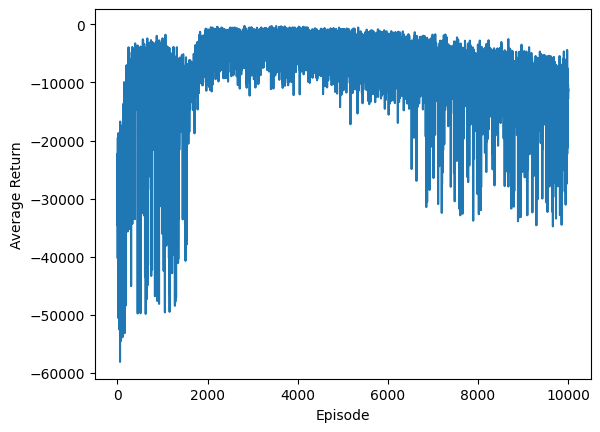

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Episode')
plt.ylim()
plt.savefig("sac_learning_curve.svg", bbox_inches='tight')

In [ ]:
max(returns)

-249.65118

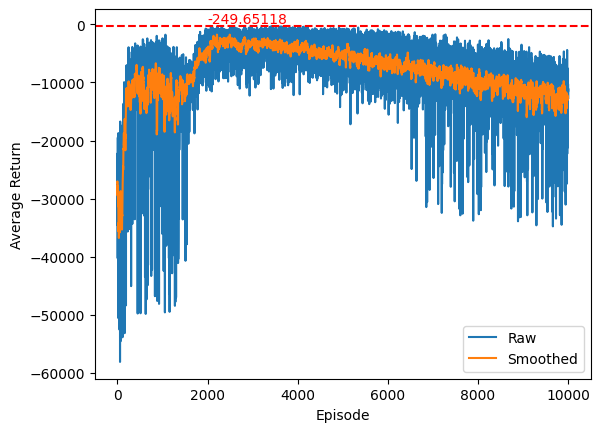

In [ ]:
data = np.array(returns)
cumsum_data = np.cumsum(data)
returns_vec = (cumsum_data[15:] - cumsum_data[:-15]) / 15 # moving average
steps = range(0, len(returns_vec), eval_interval)
plt.plot(range(0, num_iterations + 1, eval_interval), returns)
plt.plot(steps, returns_vec)
plt.ylabel('Average Return')
plt.xlabel('Episode')
plt.ylim()
plt.legend(['Raw', 'Smoothed'])
plt.axhline(y=max(returns), color='r', linestyle='--')
plt.text(2000, max(returns) + 500, s=str(max(returns)), c='r')
plt.savefig("sac_learning_curve.svg", bbox_inches='tight')

In [ ]:
max(returns_vec)

-1255.0